# Decision making under uncertainty

In this lecture, you learned about how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We considered the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. In this assignment, you will solve a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the lecture slides and also in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf

Your task is to reproduce the plots from Figure 9 of the paper, interpret the results, and explain the steps of the solution.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

## 0. Define the parameters of the model (0.5 pts)

In [18]:
# INSERT CODE HERE
mu1 = 6
mu2 = 4
sigma = 1
r_c = -0.1
r_1 = [1,0]
r_2 = [0,1]


## 1. Updating the belief state  (2.5 pts)
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state'). 

### 1a. Write a function that will calculate this posterior given the prior belief and an observation (the belief update). (0.5 pt)

In [19]:
# INSERT CODE BELOW
def belief_state(c=0):
    p_c_given_x1 = scipy.stats.norm.pdf(c,loc=mu1,scale=sigma)
    p_c_given_x2 = scipy.stats.norm.pdf(c,loc=mu2,scale=sigma)
    
    p_x1_given_c = (0.5* p_c_given_x1) / (0.5*p_c_given_x1 + 0.5*p_c_given_x2)
    p_x2_given_c = (0.5*p_c_given_x2) / (0.5*p_c_given_x1 + 0.5*p_c_given_x2)
    

    return p_x1_given_c, p_x2_given_c

### 1b. Use this function to update the belief on the first observation at step $\beta$ and reproduce Fig 9A.  Interpret the plot. (1 pt)

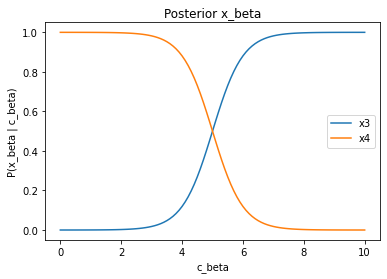

In [756]:
# INSERT CODE BELOW
cs = np.linspace(0,10,101)

beliefs = np.zeros(shape=(101,2))
for c in range(cs.shape[0]):
    beliefs[c,:] = belief_state(cs[c])
plt.plot(cs, beliefs[:,0], label = "x3")
plt.plot(cs, beliefs[:,1], label="x4");
plt.xlabel("c_beta")
plt.ylabel("P(x_beta | c_beta)")
plt.title("Posterior x_beta")
plt.legend()
plt.show()


The posterior shows the belief state. It describes how sure we are that the observed stimulus c_beta belongs to state x3 or x4. For c_beta = 5, the porbability of being in state x3 and x4 are the same at p=0.5.  

### 1c. Write a function to update the belief on observing another sample at step $\alpha$ and reproduce Fig 9B.  Interpret the plot. (1 pt)
Hint: You will have to calculate this probability for every possible pair of observations.

In [5]:
# INSERT CODE BELOW
def update_belief_state_alpha(c_alpha, c_beta):

    p_c_alpha_given_x1 = scipy.stats.norm(loc=mu1,scale=sigma).pdf(c_alpha)
    p_c_alpha_given_x2 = scipy.stats.norm(loc=mu2,scale=sigma).pdf(c_alpha)
    p_c_beta_given_x3 = scipy.stats.norm(loc=mu1,scale=sigma).pdf(c_beta)
    p_c_beta_given_x4 = scipy.stats.norm(loc=mu2,scale=sigma).pdf(c_beta)
    
    p_x1_given_c_a_c_b_x3 =  p_c_alpha_given_x1 *p_c_beta_given_x3 #* p_x3_given_c_beta
    p_x2_given_c_a_c_b_x4 =  p_c_alpha_given_x2 *p_c_beta_given_x4 #* p_x4_given_c_beta

    p_x1_given_c_a_c_b = p_x1_given_c_a_c_b_x3 / (p_x1_given_c_a_c_b_x3  + p_x2_given_c_a_c_b_x4)
    return p_x1_given_c_a_c_b

In [714]:
n = 101
cs = np.linspace(0,10,n)

beliefs = np.zeros(shape=(n,n))
for c_beta in range(cs.shape[0]):
    for c_alpha in range(cs.shape[0]):
        beliefs[c_beta,c_alpha] = update_belief_state_alpha(c_alpha=cs[c_alpha], c_beta=cs[c_beta])



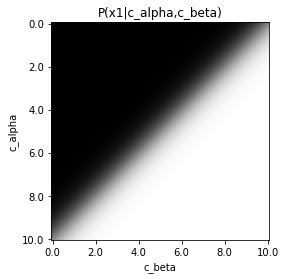

In [754]:
plt.imshow(beliefs, cmap='gray')
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(n//10), ticks)
plt.yticks(ticks*(n//10), ticks)
plt.xlabel("c_beta")
plt.ylabel("c_alpha")
plt.title("P(x1|c_alpha,c_beta)")
plt.show()

Now we have two observations: c_alpha and c_beta. The graph shows the probability of being in state x1. White means the probability is 1, while black means 0. The probability of being in x2 given the stimuli is 1-P(x1|c_alpha, c_beta). The uncertainty is highest in the diagonal. For example when both stimuli were 5, it could have come from the two distributions with the same likelihood. But if both stimuli are well above 5 it is very likely that they came from distribution 1. 

## 2. Solving for the optimal actions (7 pts)
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy'). 

### 2a. When finding the optimal policy, why does it make sense to calculate the best action at the final stage $\alpha$, and work backwards? (1 pt)

Because there is only two actions at the end which are immediately followed by rewards. So, to calculate the expected Value you only need the belief state and reward. For stage beta, you need the value of stage alpha, so it makes sense to calculate that first.

### 2b. Write a function that will calculate the value of the best action at $\alpha$ and reproduce Fig 9C. Explain what the plot shows. (1 pt)

In [22]:
# INSERT CODE BELOW
def value_at_alpha(posterior_x1, posterior_x2):
    v_alpha = np.max((posterior_x1 * np.max(r_1), posterior_x2 * np.max(r_2)), axis=0)
    return v_alpha

In [752]:
n = 101
cs = np.linspace(0,10,n)

beliefs = np.zeros(shape=(n,n))
vs = np.zeros(shape=(n,n))
for c_beta in range(cs.shape[0]):
    for c_alpha in range(cs.shape[0]):
        beliefs[c_beta,c_alpha] = update_belief_state_alpha(c_alpha=cs[c_alpha], c_beta=cs[c_beta])
        vs[c_beta,c_alpha] = value_at_alpha(beliefs[c_beta,c_alpha], 1-beliefs[c_beta,c_alpha])



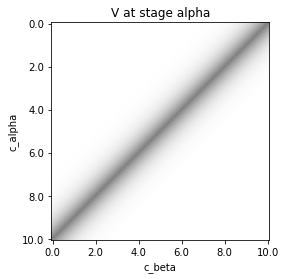

In [753]:
plt.imshow(vs, cmap='gray', vmin=0, vmax=1)
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(n//10), ticks)
plt.yticks(ticks*(n//10), ticks)
plt.xlabel("c_beta")
plt.ylabel("c_alpha")
plt.title("V at stage alpha")
plt.show()


The plot shows the expected Q value at stage alpha based on the two observations. There is an area of uncertainty in the diagonal, but everywhere else it is close to 1. The reward of 1 can be achieved when the state is known. If the state is uncertain, a final action will be guessed, and a reward can be assumed in 50% of cases. That is why the diagonal has a minimum value of 0.5.  

### 2c. Before finding the best action at $\beta$, we have one more step to do. We need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_{\alpha}$ given $c_{\beta}$ ($P(c_{\alpha} | c_{\beta})$). Why? (1 pt)

The value at stage alpha depends on how sure we are that we are in one of the two states. The achieved reward depends on the belief state. To update the belief state after observing a second c, we need the probability of P(c_alpha|c_beta). 

### 2d. Write a function that will calculate $P(c_{\alpha} | c_{\beta})$ and reproduce Fig 9D. Explain how you calculated this probability and what the plot shows. (1 pt)
Hint: You will have to marginalise the posteriors over the possible states.

In [14]:
# INSERT CODE BELOW
def get_c_alpha_given_c_beta(c_alpha, c_beta):
    p_c_alpha_given_x1 = scipy.stats.norm(loc=mu1,scale=sigma).pdf(c_alpha)
    p_c_alpha_given_x2 = scipy.stats.norm(loc=mu2,scale=sigma).pdf(c_alpha)
    p_c_beta_given_x3 = scipy.stats.norm(loc=mu1,scale=sigma).pdf(c_beta)
    p_c_beta_given_x4 = scipy.stats.norm(loc=mu2,scale=sigma).pdf(c_beta)


    prob_c_alpha_and_c_beta = p_c_alpha_given_x1 * p_c_beta_given_x3 + p_c_alpha_given_x2 * p_c_beta_given_x4
    prob_c_beta = 0.5*(p_c_beta_given_x3 + p_c_beta_given_x4)
    c_alpha_given_c_beta = prob_c_alpha_and_c_beta / prob_c_beta
    return c_alpha_given_c_beta

In [28]:
n = 51
cs = np.linspace(0,10,n)

ps = np.zeros(shape=(n,n))
for c_beta in range(cs.shape[0]):
    for c_alpha in range(cs.shape[0]):
        ps[c_beta,c_alpha] = get_c_alpha_given_c_beta(c_alpha=cs[c_alpha], c_beta=cs[c_beta])



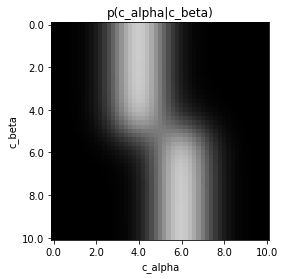

In [29]:
plt.imshow(ps, cmap='gray', vmin=0, vmax=1)
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(n//10), ticks)
plt.yticks(ticks*(n//10), ticks)
plt.xlabel("c_alpha")
plt.ylabel("c_beta")
plt.title("p(c_alpha|c_beta)")
plt.show()


This plot shows how likely it is to observe a specific c_alpha given a c_beta. It can be seen that some values for c alpha are always unlikely, for example c<1 and c>9. Other values like c_alpha = 3 are unlikely for c_beta > 6 but likely for c_beta < 6. This is because c_beta already gives information about the distribution. Possible observations c_alpha that fall into this distribution are more likely to be observed. For c_beta < 4, c_alpha = 4 is most likely, and for c_beta > 6, c_alpha = 6 is most likely. These observations are the means of the two distributions. Around c_beta = 5, there is no certain information about which distribution the stimulus belongs to. Therefore, there is an area of uncertainty.  

### 2e. We are now ready to find the best action at $\beta$. Write a function that calculates the values associated with each of the actions and reproduce Fig 9E. What does the plot tell you about what the best action is at $\beta$? (1 pt)
Hint: For action C, you will have to numerically integrate over possible observations ${c_{\alpha}}$ using the step size ($dc_{\alpha}$) you defined on your Gaussian observation distribution. 

In [23]:
# INSERT CODE BELOW
def q_value_at_beta(c_beta):
    qs = np.zeros(3)
    ps_belief_state = belief_state(c_beta)
    qs[0] = ps_belief_state[0] * r_1[0]
    qs[1] = ps_belief_state[1] * r_2[1]
    

    return qs

def integrate(c_alpha_values, c_beta, p_c_alpha_given_x):
    beliefs = update_belief_state_alpha(c_alpha_values, c_beta)
    value_at_alph = value_at_alpha(beliefs, 1-beliefs)
    
    return value_at_alph * p_c_alpha_given_x


def q_value_c_at_beta(c_beta):
    # return q
    lower_limit = 0
    upper_limit = 10
    step_size = 0.01
    # Generate values for c_alpha
    c_alpha_values = np.arange(lower_limit, upper_limit + step_size, step_size)
    p_c_alpha_given_x1 = scipy.stats.norm(loc=mu1,scale=sigma).pdf(c_alpha_values)
    p_c_alpha_given_x2 = scipy.stats.norm(loc=mu2,scale=sigma).pdf(c_alpha_values)
    values1 = integrate(c_alpha_values, c_beta, p_c_alpha_given_x1)
    values2 = integrate(c_alpha_values, c_beta, p_c_alpha_given_x2)

    # Perform numerical integration using the trapezoidal rule
    integral_result = np.trapz(values1, c_alpha_values,step_size)
    integral_result2 = np.trapz(values2, c_alpha_values,step_size)

    return r_c + belief_state(c_beta)[0]*integral_result + belief_state(c_beta)[1]*integral_result2 #+ belief_state(c_beta)[0]*integral_result2 + belief_state(c_beta)[1]*integral_result



In [765]:
n = 101
cs = np.linspace(0,10,n)

qs_beta = np.zeros(shape=(n,3))
for c_beta in range(cs.shape[0]):
    qs_beta[c_beta,] = q_value_at_beta(c_beta=cs[c_beta])
    qs_beta[c_beta,2] = q_value_c_at_beta(c_beta=cs[c_beta])


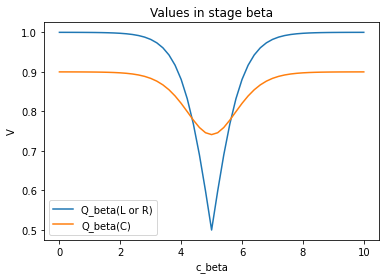

In [766]:
plt.plot(cs, np.max(qs_beta[:,:2], axis=1), label = "Q_beta(L or R)")
plt.plot(cs, qs_beta[:,2], label = "Q_beta(C)")
plt.xlabel("c_beta")
plt.ylabel("V")
plt.title("Values in stage beta")

plt.legend();

For c_beta < 4.1 and c_beta > 5.9, the expected value of directly choosing A or B is higher than choosing C. But for the other observations, the cost of probing is lower than the gain of information that leads to getting more rewards. Therefore for 4.1 < c_beta < 5.9, it is better to choose C.

### 2f. What will reduce (or increase) the range of observations at $\beta$ where it is best to choose to wait for another observation (choosing C)? Can you tweak a parameter to do this and produce a plot similar to Fig 9E to show this? (2 pts)
Hint: You will have to re-run the steps with this changed parameter. 

In [26]:
# INSERT CODE BELOW
mu1 = 6
mu2 = 4
sigma = 1
r_c = -0.1
r_1 = [100,0]
r_2 = [0,100]

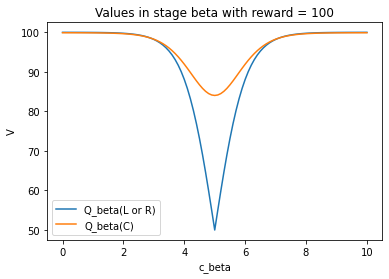

In [27]:
n = 101
cs = np.linspace(0,10,n)

qs_beta = np.zeros(shape=(n,3))
for c_beta in range(cs.shape[0]):
    qs_beta[c_beta,] = q_value_at_beta(c_beta=cs[c_beta])
    qs_beta[c_beta,2] = q_value_c_at_beta(c_beta=cs[c_beta])
plt.plot(cs, np.max(qs_beta[:,:2], axis=1), label = "Q_beta(L or R)")
plt.plot(cs, qs_beta[:,2], label = "Q_beta(C)")
plt.xlabel("c_beta")
plt.ylabel("V")
plt.legend()
plt.title("Values in stage beta with reward = 100");


Increasing the rewards to 100 makes the cost of probing (-0.1) small in comparison. Therefore the expected value of choosing C is higher than directly going for L or R in a larger range of c_beta. Waiting for a second observation increases the chance of a reward because the probability that the belief state matches the real state increases.
Decreasing the reward would have the opposite effect, because the cost of probing becomes higher in comparison. 

Increasing the cost of probing would have similar effects as decreasing the rewards and vice versa. 

Shifting the means of the two distributions closer together would increase the range where C is chosen. 